In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored
from tqdm import tqdm
from math import log, exp, ceil

2023-10-10 00:11:57.256893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 00:11:58.757751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def run2(iterations: int, variable_noise:bool, env=None, agent=None, method="Iterations_Only", isplot:bool = True,
    alpha:float = 0.0002, beta:float = 0.0004, noise:float = 0.02, batch_size:int = 128, warmup:int = 0,
    uniform_selection:bool=True, TD3:bool=False, TD3_update_interval:int=2, last_layer_activation:str="sigmoid",
    multi_actor:bool=False, multi_out_layer:bool = False, reward_function:str = "product*sumrate",
    buffer_size:int = 10000, num_of_actors:int = 4, dummy_actor_input:bool = False, initial_noise:float = 0.5):

    sigma = 1e-2

    if env == None : 
        env = Environment(num_of_antennas=20, num_of_irs1=20, num_of_irs2=20,
                    path_loss_exponent=2, irs1_to_antenna=20,
                    irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
                    state_dB=False, without_irs=False)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                    noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                                    los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                   los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)
        
    if multi_actor :
        num_of_actions = [env.M1, env.M2]
        for _ in range(env.num_of_users):
            num_of_actions.append(env.N)
    else:
        num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None :
        agent = Agent(num_states=env.num_of_users, bound=2, batch_size=batch_size, buffer_size=buffer_size,
                        env=env, n_actions=num_of_actions, warmup=warmup,uniform_selection=uniform_selection,
                        noise=0.055, alpha=alpha, beta=beta, fc1=512, fc2=256, TD3=TD3, TD3_update_interval=TD3_update_interval,
                        last_layer_activation=last_layer_activation, multi_actor=multi_actor, multi_out_layer=multi_out_layer,
                        num_of_actors=num_of_actors,dummy_actor_input=dummy_actor_input)


    num_of_iterations = iterations
    rewards = np.zeros((1, num_of_iterations))
    sumrate = np.zeros((1, num_of_iterations))
    U1_SINR = np.zeros((1, num_of_iterations))
    U2_SINR = np.zeros((1, num_of_iterations))

    obs = env.State()

    for iter in tqdm(range(num_of_iterations), desc= colored("Agent is Learning \U0001f600 ", "green"), ncols=123, colour= "red"):

        if iter == num_of_iterations - 1:
            env.last = True

        if variable_noise :
            if iter < num_of_iterations / 2:
                agent.noise = (initial_noise) * exp(-(iter / num_of_iterations) ** 1)

            else:
                agent.noise = (initial_noise) * exp(-(iter / (num_of_iterations/2)) ** 1.8)
            
        else:
            agent.noise = noise

        action = agent.choose_action(obs)

        new_state, reward, sumrate[0][iter], SINRs = env.Step(action)
        # if reward != 0 : 
        agent.remember(obs, action, reward, new_state)
            
        agent.learn()
        obs = new_state
        rewards[0][iter] = reward
        U1_SINR[0][iter] = SINRs[0]
        U2_SINR[0][iter] = SINRs[1]

    
    # print(np.array(action)[-1])
    data = [sumrate, U1_SINR, U2_SINR]

    last_sumrate, last_u1_sinr, last_u2_sinr = plot(score_history=np.array([1]), sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method, isplot=isplot)

    return agent, last_sumrate, last_u1_sinr, last_u2_sinr, data


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.28it/s]


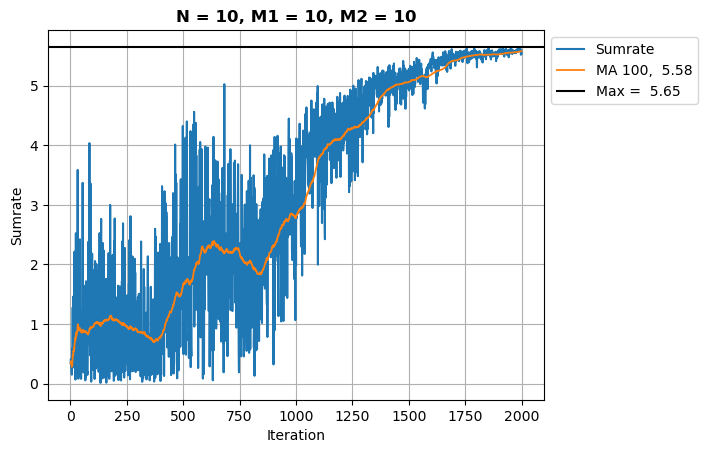

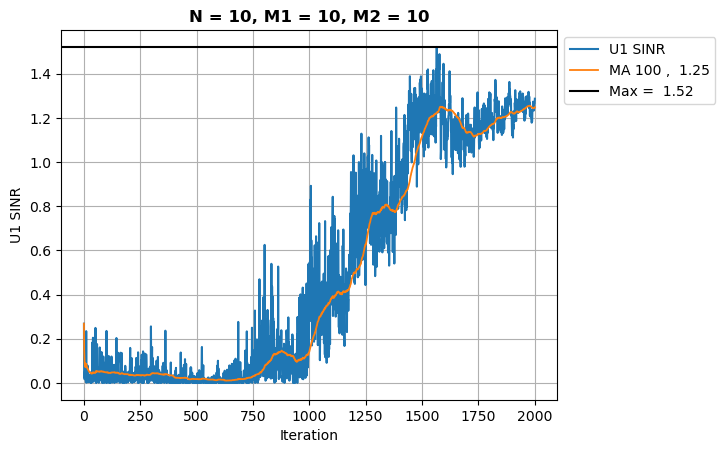

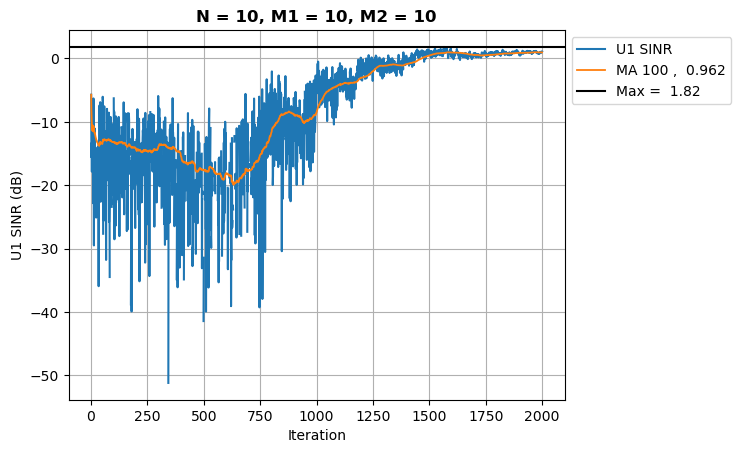

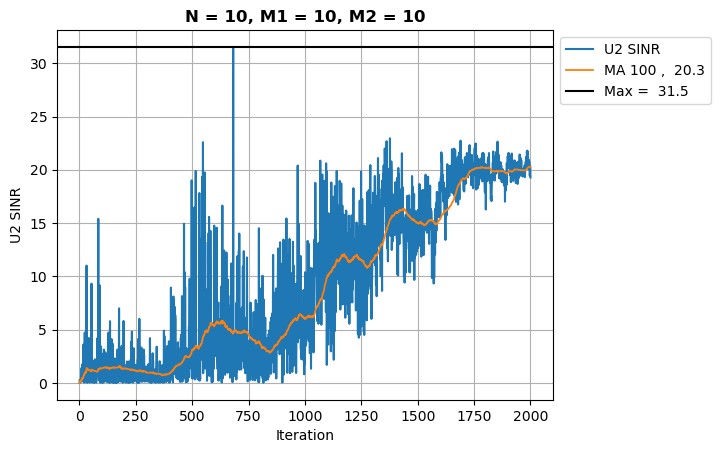

/home/danesh/Desktop/IRS-Project/src/plot.py:183: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(1, len(moving_average) + 1), 10 * np.log10(moving_average),


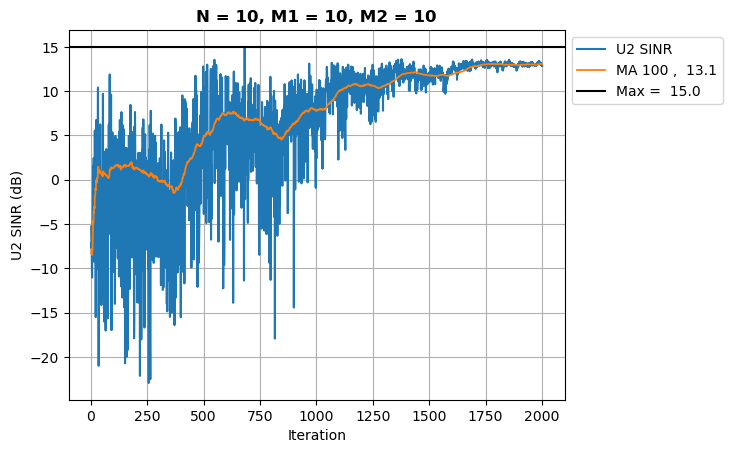

In [17]:
sigma = 1e-2
env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
              path_loss_exponent=2, irs1_to_antenna=20,
              irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
              state_dB=False, without_irs=False, double_reflection=True, no_irs=False)

U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                            los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1, data = run2(2000, variable_noise=True, env=env, isplot=True, alpha=0.0002,
                            beta=0.0004, batch_size=128, multi_actor=True, last_layer_activation="tanh", buffer_size=500,
                            num_of_actors=4,)



In [16]:
scenario = "with_block_man6"
import matplotlib.pyplot as plt

np.save(f'D_MA_sumrates_{scenario}.npy', data[0][0])
np.save(f'D_MA_u1_sinr_{scenario}.npy', data[1][0])
np.save(f'D_MA_u2_sinr_{scenario}.npy', data[2][0])


# a = np.load("D_MA_sumrates_with_block_man2.npy")
# plt.plot(a)
# a[-1]


In [42]:
import matplotlib.pyplot as plt
num_of_runs = 5
sigma = 1e-2
irs1_elements = [5, 10, 20, 30, 40, 50]

final_sumrates = np.zeros((len(irs1_elements),))
final_u1_rates = np.zeros((len(irs1_elements),))
final_u2_rates = np.zeros((len(irs1_elements),))

for indx, elemnt_num in enumerate(irs1_elements):
       sumrates = np.zeros((num_of_runs,))
       u1_rates = np.zeros((num_of_runs,))
       u2_rates = np.zeros((num_of_runs,))


       for _ in range(num_of_runs):
       
              env = Environment(num_of_antennas=10, num_of_irs1=elemnt_num, num_of_irs2=10,
              path_loss_exponent=2, irs1_to_antenna=20,
              irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
              state_dB=False, without_irs=True, double_reflection=True, no_irs=True)

              U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                          noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                          los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

              U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                                          noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                          los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


              agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1 = run2(2000, variable_noise=True, env=env, isplot=False, alpha=0.0002,
                                          beta=0.0004, batch_size=128, multi_actor=True, last_layer_activation="tanh", buffer_size=500,
                                          num_of_actors=4,)
              
              
              

              sumrates[_] = last_sumrate1
              u1_rates[_] = np.log2(1+last_u1_sinr1)
              u2_rates[_] = np.log2(1+last_u2_sinr1)


              print(f"Iter:{_ + 1 : < 5} Sumrate = {last_sumrate1: < 10.3} U1_Rate_1 = {np.log2(1+last_u1_sinr1): < 10.3}\
       U2_Rate_1 = {np.log2(1+last_u2_sinr1) : < 10.3}")     


       final_sumrates[indx] = sumrates.max()
       final_u1_rates[indx] = u1_rates.max()
       final_u2_rates[indx] = u2_rates.max()



       print(f"Sumrate_1 = {final_sumrates[indx] : < 10.3} U1_Rate_1 = {final_u1_rates[indx]: < 10.3}\
       U2_Rate_1 = {final_u2_rates[indx] : < 10.3}")     
       print("\n")
      

plt.plot(irs1_elements, final_sumrates, label="Sumrate", linewidth=2)
plt.ylabel("Sumrate")
plt.xlabel("Number of IRS1 Elements")
plt.title("Sumrate vs Number of IRS1 Elements")
plt.grid(1)
plt.show()

fig , ax = plt.subplots(2,1)
ax[0].plot(irs1_elements, final_u1_rates, label="U1 Rate", linewidth=2)
ax[0].set_ylabel("U1 Rate")
ax[0].set_xlabel("Number of IRS1 Elements")
ax[0].grid(1)

ax[1].plot(irs1_elements, final_u2_rates, label="U2 Rate", linewidth=2)
ax[1].set_ylabel("U2 Rate")
ax[1].set_xlabel("Number of IRS1 Elements")
ax[1].grid(1)




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.67it/s]


Iter: 1    Sumrate =  7.44      U1_Rate_1 =  3.96            U2_Rate_1 =  3.48     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.35it/s]


Iter: 2    Sumrate =  6.98      U1_Rate_1 =  3.86            U2_Rate_1 =  3.12     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 28.10it/s]


Iter: 3    Sumrate =  7.81      U1_Rate_1 =  4.2             U2_Rate_1 =  3.61     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 28.02it/s]


Iter: 4    Sumrate =  1.21      U1_Rate_1 =  0.486           U2_Rate_1 =  0.723    


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.40it/s]


Iter: 5    Sumrate =  5.02      U1_Rate_1 =  2.32            U2_Rate_1 =  2.7      
Sumrate_1 =  7.81      U1_Rate_1 =  4.2             U2_Rate_1 =  3.61     




Agent is Learning 😀 :   6%|███▊                                                        | 127/2000 [00:05<01:22, 22.77it/s]


KeyboardInterrupt: 

In [21]:
import matplotlib.pyplot as plt
num_of_runs = 5
sigma = 1e-2
irs1_elements = [5, 10, 20, 30, 40, 50]

final_sumrates_1 = np.zeros((len(irs1_elements),))
final_u1_rates_1 = np.zeros((len(irs1_elements),))
final_u2_rates_1 = np.zeros((len(irs1_elements),))

for indx, elemnt_num in enumerate(irs1_elements):
       sumrates = np.zeros((num_of_runs,))
       u1_rates = np.zeros((num_of_runs,))
       u2_rates = np.zeros((num_of_runs,))


       for _ in range(num_of_runs):
       
              env = Environment(num_of_antennas=10, num_of_irs1=elemnt_num, num_of_irs2=10,
              path_loss_exponent=2, irs1_to_antenna=20,
              irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
              state_dB=False, without_irs=True, double_reflection=True, no_irs=True)

              U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                          noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                          los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

              U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                                          noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                          los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


              agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1 = run2(2000, variable_noise=True, env=env, isplot=False, alpha=0.0002,
                                          beta=0.0004, batch_size=128, multi_actor=True, last_layer_activation="tanh", buffer_size=500,
                                          num_of_actors=4,)
              
              
              

              sumrates[_] = last_sumrate1
              u1_rates[_] = np.log2(1+last_u1_sinr1)
              u2_rates[_] = np.log2(1+last_u2_sinr1)


              print(f"Iter:{_ + 1 : < 5} Sumrate = {last_sumrate1: < 10.3} U1_Rate_1 = {np.log2(1+last_u1_sinr1): < 10.3}\
       U2_Rate_1 = {np.log2(1+last_u2_sinr1) : < 10.3}")     


       final_sumrates_1[indx] = sumrates.max()
       final_u1_rates_1[indx] = u1_rates.max()
       final_u2_rates_1[indx] = u2_rates.max()



       print(f"Sumrate_1 = {final_sumrates_1[indx] : < 10.3} U1_Rate_1 = {final_u1_rates_1[indx]: < 10.3}\
       U2_Rate_1 = {final_u2_rates_1[indx] : < 10.3}")     
       print("\n")
      




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 27.88it/s]


Iter: 1    Sumrate =  7.44      U1_Rate_1 =  3.92            U2_Rate_1 =  3.53     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.00it/s]


Iter: 2    Sumrate =  7.54      U1_Rate_1 =  4.16            U2_Rate_1 =  3.38     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:06<00:00, 30.24it/s]


Iter: 3    Sumrate =  7.56      U1_Rate_1 =  4.04            U2_Rate_1 =  3.53     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.94it/s]


Iter: 4    Sumrate =  6.96      U1_Rate_1 =  3.26            U2_Rate_1 =  3.7      


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.01it/s]


Iter: 5    Sumrate =  2.66      U1_Rate_1 =  2.31            U2_Rate_1 =  0.353    
Sumrate_1 =  7.56      U1_Rate_1 =  4.16            U2_Rate_1 =  3.7      




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.94it/s]


Iter: 1    Sumrate =  8.12      U1_Rate_1 =  4.42            U2_Rate_1 =  3.7      


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.89it/s]


Iter: 2    Sumrate =  6.86      U1_Rate_1 =  3.82            U2_Rate_1 =  3.04     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.01it/s]


Iter: 3    Sumrate =  7.5       U1_Rate_1 =  4.32            U2_Rate_1 =  3.18     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.86it/s]


Iter: 4    Sumrate =  7.5       U1_Rate_1 =  3.87            U2_Rate_1 =  3.63     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.16it/s]


Iter: 5    Sumrate =  7.63      U1_Rate_1 =  4.06            U2_Rate_1 =  3.56     
Sumrate_1 =  8.12      U1_Rate_1 =  4.42            U2_Rate_1 =  3.7      




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.24it/s]


Iter: 1    Sumrate =  0.984     U1_Rate_1 =  0.167           U2_Rate_1 =  0.818    


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.07it/s]


Iter: 2    Sumrate =  6.48      U1_Rate_1 =  3.76            U2_Rate_1 =  2.72     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.49it/s]


Iter: 3    Sumrate =  3.16      U1_Rate_1 =  1.68            U2_Rate_1 =  1.52     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.31it/s]


Iter: 4    Sumrate =  6.82      U1_Rate_1 =  3.82            U2_Rate_1 =  3.0      


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.12it/s]


Iter: 5    Sumrate =  7.88      U1_Rate_1 =  4.03            U2_Rate_1 =  3.84     
Sumrate_1 =  7.88      U1_Rate_1 =  4.03            U2_Rate_1 =  3.84     




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.60it/s]


Iter: 1    Sumrate =  7.8       U1_Rate_1 =  4.2             U2_Rate_1 =  3.6      


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.69it/s]


Iter: 2    Sumrate =  7.88      U1_Rate_1 =  4.48            U2_Rate_1 =  3.41     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.50it/s]


Iter: 3    Sumrate =  1.43      U1_Rate_1 =  1.35            U2_Rate_1 =  0.0787   


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.72it/s]


Iter: 4    Sumrate =  8.22      U1_Rate_1 =  4.28            U2_Rate_1 =  3.94     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.58it/s]


Iter: 5    Sumrate =  1.01      U1_Rate_1 =  0.831           U2_Rate_1 =  0.181    
Sumrate_1 =  8.22      U1_Rate_1 =  4.48            U2_Rate_1 =  3.94     




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.57it/s]


Iter: 1    Sumrate =  8.47      U1_Rate_1 =  4.67            U2_Rate_1 =  3.8      


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.52it/s]


Iter: 2    Sumrate =  7.22      U1_Rate_1 =  4.14            U2_Rate_1 =  3.08     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.53it/s]


Iter: 3    Sumrate =  7.76      U1_Rate_1 =  4.1             U2_Rate_1 =  3.67     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.49it/s]


Iter: 4    Sumrate =  0.862     U1_Rate_1 =  0.214           U2_Rate_1 =  0.649    


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.53it/s]


Iter: 5    Sumrate =  6.76      U1_Rate_1 =  4.02            U2_Rate_1 =  2.74     
Sumrate_1 =  8.47      U1_Rate_1 =  4.67            U2_Rate_1 =  3.8      




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.59it/s]


Iter: 1    Sumrate =  1.97      U1_Rate_1 =  1.96            U2_Rate_1 =  0.0127   


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.59it/s]


Iter: 2    Sumrate =  0.265     U1_Rate_1 =  0.13            U2_Rate_1 =  0.135    


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.81it/s]


Iter: 3    Sumrate =  2.39      U1_Rate_1 =  2.39            U2_Rate_1 =  0.0035   


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.87it/s]


Iter: 4    Sumrate =  1.73      U1_Rate_1 =  0.554           U2_Rate_1 =  1.18     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:23<00:00, 24.01it/s]


Iter: 5    Sumrate =  7.66      U1_Rate_1 =  4.15            U2_Rate_1 =  3.51     
Sumrate_1 =  7.66      U1_Rate_1 =  4.15            U2_Rate_1 =  3.51     




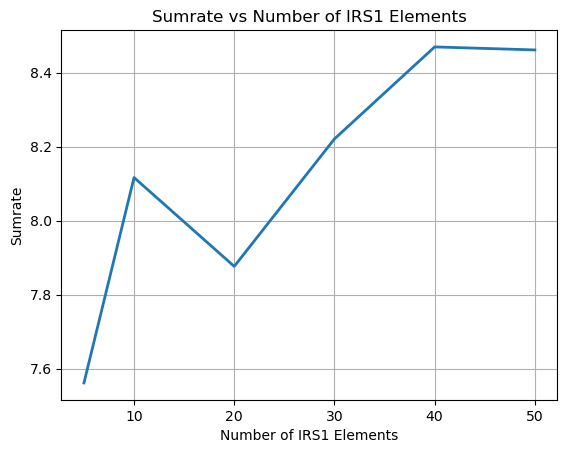

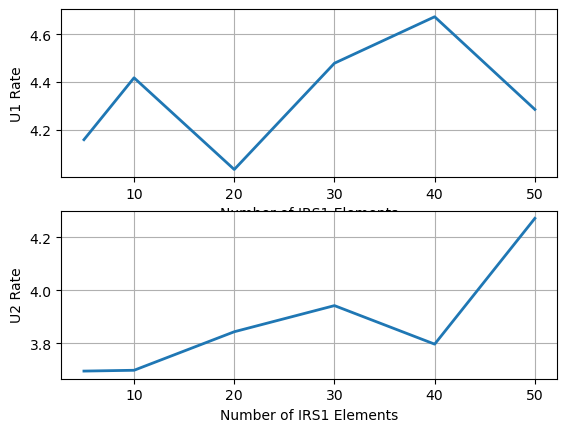

In [30]:
irs1_elements = [5, 10, 20, 30, 40, 50]
plt.plot(irs1_elements, final_sumrates_1, label="Sumrate", linewidth=2)
plt.ylabel("Sumrate")
plt.xlabel("Number of IRS1 Elements")
plt.title("Sumrate vs Number of IRS1 Elements")
plt.grid(1)
plt.show()

fig , ax = plt.subplots(2,1)
ax[0].plot(irs1_elements, final_u1_rates_1, label="U1 Rate", linewidth=2)
ax[0].set_ylabel("U1 Rate")
ax[0].set_xlabel("Number of IRS1 Elements")
ax[0].grid(1)

ax[1].plot(irs1_elements, final_u2_rates_1, label="U2 Rate", linewidth=2)
ax[1].set_ylabel("U2 Rate")
ax[1].set_xlabel("Number of IRS1 Elements")
ax[1].grid(1)
# final_sumrates[-1] = 7.91
# final_u1_rates[-1] = 3.17
# final_u2_rates[-1] = 4.87


In [46]:
np.save('D_MA_sumrates_without_blockage_M1_no_irs.npy', final_sumrates)
np.save('D_MA_u1_rates_without_blockage_M1_no_irs.npy', final_u1_rates)
np.save('D_MA_u2_rates_without_blockage_M1_no_irs.npy', final_u2_rates)
# for i in range(1 , len(irs1_elements)):
#     final_sumrates[i] = final_sumrates[0]
#     final_u1_rates[i] = final_u1_rates[0]
#     final_u2_rates[i] = final_u2_rates[0]

# final_sumrates
# final_u1_rates 
# final_u2_rates 
# final_sumrates_1[-1] = final_sumrates[-1]
# final_u1_rates_1[-1] = final_u1_rates[-1]
# final_u2_rates_1[-1] = final_u2_rates[-1]




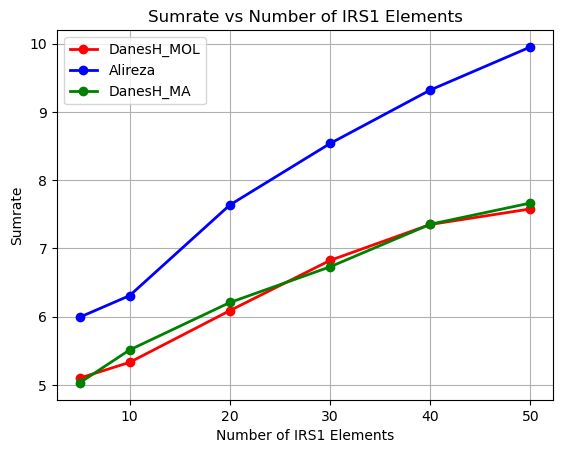

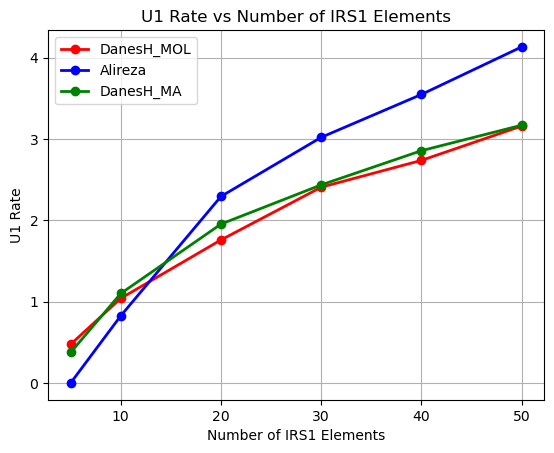

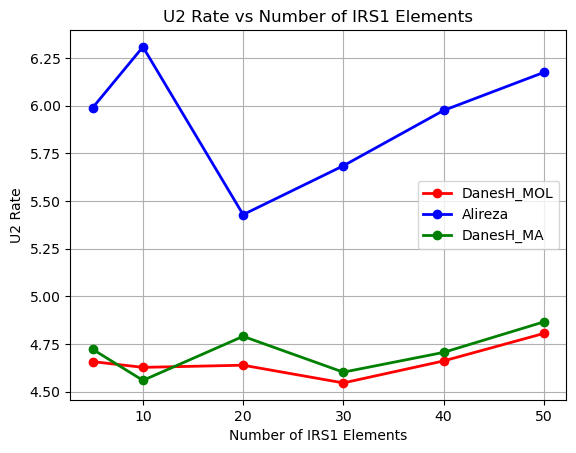

In [80]:
# print(final_sumrates)
A_sumrates = np.load("./Saved_results/A_sumrates.npy")
A_u1_rates = np.load('./Saved_results/A_u1_rates.npy')
A_u2_rates = np.load('./Saved_results/A_u2_rates.npy')

D_sumrates = np.load('./Saved_results/D1_sumrates.npy')
D_u1_rates = np.load('./Saved_results/D1_u1_rates.npy')
D_u2_rates = np.load('./Saved_results/D1_u2_rates.npy')

# D1_sumrates = np.load('../Saved_results/D2_sumrates.npy')
# D1_u1_rates = np.load('../Saved_results/D2_u1_rates.npy')
# D1_u2_rates = np.load('../Saved_results/D2_u2_rates.npy')


plt.plot(irs1_elements, final_sumrates, 'o-r', label="DanesH_MOL", linewidth=2)
plt.plot(irs1_elements, A_sumrates, 'o-b', label="Alireza", linewidth=2)
plt.plot(irs1_elements, D_sumrates, 'o-g', label="DanesH_MA", linewidth=2)
plt.ylabel("Sumrate")
plt.xlabel("Number of IRS1 Elements")
plt.title("Sumrate vs Number of IRS1 Elements")
plt.grid(1)
plt.legend()
plt.show()

plt.plot(irs1_elements, final_u1_rates, 'o-r', label="DanesH_MOL", linewidth=2)
plt.plot(irs1_elements, A_u1_rates, 'o-b', label="Alireza", linewidth=2)
plt.plot(irs1_elements, D_u1_rates, 'o-g', label="DanesH_MA", linewidth=2)
plt.ylabel("U1 Rate")
plt.xlabel("Number of IRS1 Elements")
plt.title("U1 Rate vs Number of IRS1 Elements")
plt.grid(1)
plt.legend()
plt.show()

plt.plot(irs1_elements, final_u2_rates, 'o-r', label="DanesH_MOL", linewidth=2)
plt.plot(irs1_elements, A_u2_rates, 'o-b', label="Alireza", linewidth=2)
plt.plot(irs1_elements, D_u2_rates, 'o-g', label="DanesH_MA", linewidth=2)
plt.ylabel("U2 Rate")
plt.xlabel("Number of IRS1 Elements")
plt.title("U2 Rate vs Number of IRS1 Elements")
plt.grid(1)
plt.legend()
plt.show()


# save the arrays
# np.save('D1_sumrates.npy', final_sumrates)
# np.save('D1_u1_rates.npy', final_u1_rates)
# np.save('D1_u2_rates.npy', final_u2_rates)




In [44]:
sigma = 1e-2
env1 = Environment(num_of_antennas=10, num_of_irs1=30, num_of_irs2=10,
                    path_loss_exponent=2, irs1_to_antenna=20,
                    irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="product*sumrate",
                    state_dB=False)

U11 = env1.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                            los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

U21 = env1.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


# env1.reward_function = "man3"

# agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1 = run2(2000, variable_noise=True, env=env1, isplot=True, alpha=0.0002,
#                                    beta=0.0004, batch_size=128, multi_actor=True,)

np.diag(env1.Psi2)
U11.hsu
env1.H12
U21.h2u


array([[-0.00019734+0.04999961j,  0.03739108-0.03319498j,
         0.01265896-0.04837097j,  0.02398851-0.04386971j,
        -0.03295811+0.03760004j, -0.00088516+0.04999216j,
         0.02530923+0.04312126j,  0.04998576+0.00119306j,
        -0.03841044+0.03200997j,  0.03766198-0.03288731j]])

In [ ]:
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))

[  5.80351911 102.90995479 123.30667377  60.71778774  78.84238601]
************************************************************************************
[1.80000000e+02 1.80000000e+02 1.79999979e+02 1.78838679e+02
 6.44566103e-04]
************************************************************************************
6.4951752893006685


In [19]:
print(np.linalg.norm(U11.w)**2 + np.linalg.norm(U21.w)**2)
print(U11.allocated_power , U21.allocated_power)

1.0
0.661805272102356 0.33819472789764404


In [51]:
env2.Hs1 = np.array([[-1.39157845e-02+0.04802448j,  4.98723797e-02+0.00357012j,
          4.57167136e-02+0.02024801j, -9.75271044e-07+0.05j      ,
          4.97876445e-02+0.00460331j],
        [-4.84736046e-02+0.01226008j, -4.75942272e-02-0.01532284j,
          3.20963206e-02+0.03833831j,  6.73209425e-03-0.04954472j,
         -1.05288236e-02-0.04887887j],
        [ 1.36146597e-02+0.04811072j, -3.60587687e-02+0.03463763j,
         -4.53044742e-02-0.02115431j, -4.40752055e-02+0.02360882j,
         -1.44311023e-02-0.04787216j],
        [-4.22683540e-02+0.02670929j,  1.53889205e-02+0.0475729j ,
          4.96757565e-02+0.005685j  , -3.85290239e-02+0.03186714j,
         -1.40337813e-02-0.04799013j],
        [-4.91778961e-02-0.00902965j, -3.63454091e-02-0.03433673j,
         -4.92973144e-02-0.00835313j, -5.25563359e-03-0.04972302j,
         -4.76884975e-02-0.01502688j]])

env2.Hs2 = np.array([[ 0.00771954+0.03242715j, -0.0049861 -0.03295831j,
         -0.00374419+0.03312238j,  0.03079735+0.01275282j,
         -0.0071466 -0.03255821j],
        [ 0.02033193+0.02641446j,  0.00311422-0.03318754j,
          0.02324321+0.02389277j, -0.02144829-0.02551631j,
         -0.0258206 -0.02108098j],
        [-0.00967346-0.03189883j, -0.02598846-0.02087369j,
         -0.02409072+0.02303797j,  0.02313057-0.02400183j,
          0.00233047-0.03325177j],
        [-0.02463432-0.02245576j,  0.02376565+0.02337317j,
          0.01498286-0.02977625j, -0.02501869-0.02202672j,
          0.00616734-0.03275782j],
        [ 0.0117273 -0.03120227j, -0.01602094+0.02923082j,
          0.00397334+0.03309568j,  0.02993896-0.01465503j,
          0.0299354 -0.0146623j ]])


env2.H12 = np.array([[-0.01160611+0.02214268j, -0.02496921+0.00124038j,
         -0.01467783+0.02023762j,  0.00682238+0.02405109j,
         -0.02421769-0.0062051j ],
        [ 0.02348206-0.00857862j,  0.01426761+0.02052889j,
         -0.02380184-0.00764672j,  0.01999038-0.01501282j,
          0.01738457+0.01796599j],
        [-0.01238819+0.0217148j ,  0.01403245+0.02069034j,
          0.01703498+0.0182978j , -0.02498258-0.00093309j,
          0.02435191+0.00565548j],
        [-0.02456087+0.00466513j,  0.00580584-0.0243165j ,
         -0.02224717-0.01140453j,  0.01676392+0.01854646j,
         -0.02302196+0.00974625j],
        [ 0.02269704+0.01048066j, -0.01566254+0.01948551j,
          0.01064944-0.02261834j,  0.01416104+0.02060255j,
          0.02001837+0.01497547j]])


env2.H21 = np.array([[-0.01160611-0.02214268j,  0.02348206+0.00857862j,
         -0.01238819-0.0217148j , -0.02456087-0.00466513j,
          0.02269704-0.01048066j],
        [-0.02496921-0.00124038j,  0.01426761-0.02052889j,
          0.01403245-0.02069034j,  0.00580584+0.0243165j ,
         -0.01566254-0.01948551j],
        [-0.01467783-0.02023762j, -0.02380184+0.00764672j,
          0.01703498-0.0182978j , -0.02224717+0.01140453j,
          0.01064944+0.02261834j],
        [ 0.00682238-0.02405109j,  0.01999038+0.01501282j,
         -0.02498258+0.00093309j,  0.01676392-0.01854646j,
          0.01416104-0.02060255j],
        [-0.02421769+0.0062051j ,  0.01738457-0.01796599j,
          0.02435191-0.00565548j, -0.02302196-0.00974625j,
          0.02001837-0.01497547j]])


env2.Psi1 = np.array([[-0.999986  -0.00529091j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        , -0.34527467-0.93850168j,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.99212333+0.12526495j,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        , -0.24409146-0.96975222j,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.2647416 -0.96431939j]])

env2.Psi2 = np.array([[-0.99529805-0.09685968j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        , -0.74457959+0.6675337j ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.29635851+0.95507677j,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.88662796-0.46248336j,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
         -0.53906467+0.84226438j]])

U12.h1u = np.array([[ 0.00083847-0.01998242j, -0.01136959-0.01645395j,
          0.01943746+0.0047101j , -0.01586966-0.01217184j,
         -0.00981436-0.01742637j]])


U12.hsu = np.array([[-0.01591654-0.01211048j, -0.01598705+0.01201724j,
         -0.00597682-0.01908606j, -0.00349381+0.01969247j,
          0.01996058+0.0012551j ]])

U12.h2u = np.array([[-0.00292863-0.03320443j,  0.02225285+0.02481777j,
          0.00430818+0.03305375j, -0.03228555+0.00829182j,
          0.02772527+0.01850461j]])

U12.w = np.array([[ 0.09734487-0.01240598j],
        [ 0.03206944+0.0919138j ],
        [ 0.08768292-0.06697427j],
        [-0.03901275+0.12082483j],
        [-0.1209271 -0.03911317j]])

U22.h1u =  np.array([[-0.02136848-0.01297644j, -0.00277031+0.02484603j,
         -0.02482945+0.00291521j, -0.01187289+0.02200079j,
          0.00922384-0.0232362j ]])

U22.hsu = np.array([[-0.01602768-0.00457071j,  0.01632651+0.00335005j,
          0.01225691+0.01129363j, -0.01404304-0.00897613j,
          0.00890253-0.01408981j]])

U22.h2u = np.array([[ 0.04884074-0.0107043j ,  0.01581273+0.04743372j,
         -0.04546885+0.02079864j,  0.04535134+0.02105364j,
         -0.02544751+0.0430398j ]])

U22.w = np.array([[-0.10879836+0.05018858j],
        [ 0.08837533-0.07431106j],
        [ 0.09622013-0.06193018j],
        [-0.10188884+0.06048772j],
        [ 0.05499567+0.04633025j]])

env2.CalculateSINR()
print(env2.SINR, env2.SumRate)

print(f"Theta1 : {np.diag(np.angle(env2.Psi1, deg=True))}")
print(f"Theta2 : {np.diag(np.angle(env2.Psi2, deg=True))}")

print(f"Rate 1 : {np.log2(1 + env2.SINR[0])}")
print(f"Rate 2 : {np.log2(1 + env2.SINR[1])}")



[1.6379136654752489, 1.4169128074500914] 2.6725627757280077
Theta1 : [-179.69685177 -110.19856353    7.19605653 -104.12814814  -74.64840081]
Theta2 : [-174.44163469  138.12300139   72.76098256  -27.54747068  122.61998948]
Rate 1 : 1.3993973483540814
Rate 2 : 1.2731654273739264
